In [ ]:
import pandas as pd
import numpy as np

# Load your CSV with accuracy columns
csv_path = "./dataset/swe_bench_token_cost_aggregated_total_with_accuracy.csv"
df = pd.read_csv(csv_path)

# List of base metric names (without _runX suffix)
base_metrics = [
    "total_prompt_tokens", "total_completion_tokens", "total_total_tokens",
    "total_cache_creation_input_tokens", "total_cache_read_input_tokens", "total_cached_tokens",
    "total_tool_usages", "total_tool_usage_str_replace_editor", "total_tool_usage_execute_bash",
    "total_tool_usage_think", "total_tool_usage_finish", "total_interaction_rounds", "total_cost"
]

# Compute mean, var, and CV for each metric across 4 runs
for base in base_metrics:
    run_cols = [f"{base}_run{i}" for i in range(1, 5)]
    df[base + "_mean"] = df[run_cols].mean(axis=1)
    df[base + "_var"] = df[run_cols].var(axis=1)
    df[base + "_cv"] = df[run_cols].std(axis=1) / (df[base + "_mean"] + 1e-8)  # add epsilon to avoid div by 0

# Show example output
summary_cols = []
for base in base_metrics:
    summary_cols.extend([f"{base}_mean", f"{base}_var", f"{base}_cv"])

print("Per-instance mean, variance, and CV for each metric:")
print(df[summary_cols].head(10))  # show first 10 rows

# Optional: Save updated CSV
# df.to_csv("/home/longju/llm_token_predictor/oh_analysis/swe_bench_token_cost_with_stats.csv", index=False)



Per-instance mean, variance, and CV for each metric:
   total_prompt_tokens_mean  total_prompt_tokens_var  total_prompt_tokens_cv  \
0                1568999.00             1.390631e+11                0.237675   
1                 539891.50             6.188063e+10                0.460756   
2                1176829.50             1.162724e+12                0.916273   
3                1124249.00             1.843453e+11                0.381903   
4                4079917.00             5.247475e+12                0.561467   
5                1751645.75             1.023246e+12                0.577489   
6                1596165.25             1.656675e+12                0.806382   
7                1400482.75             3.606714e+12                1.356057   
8                2579382.25             1.198091e+13                1.341928   
9                 786174.50             2.827236e+10                0.213876   

   total_completion_tokens_mean  total_completion_tokens_var  \
0 

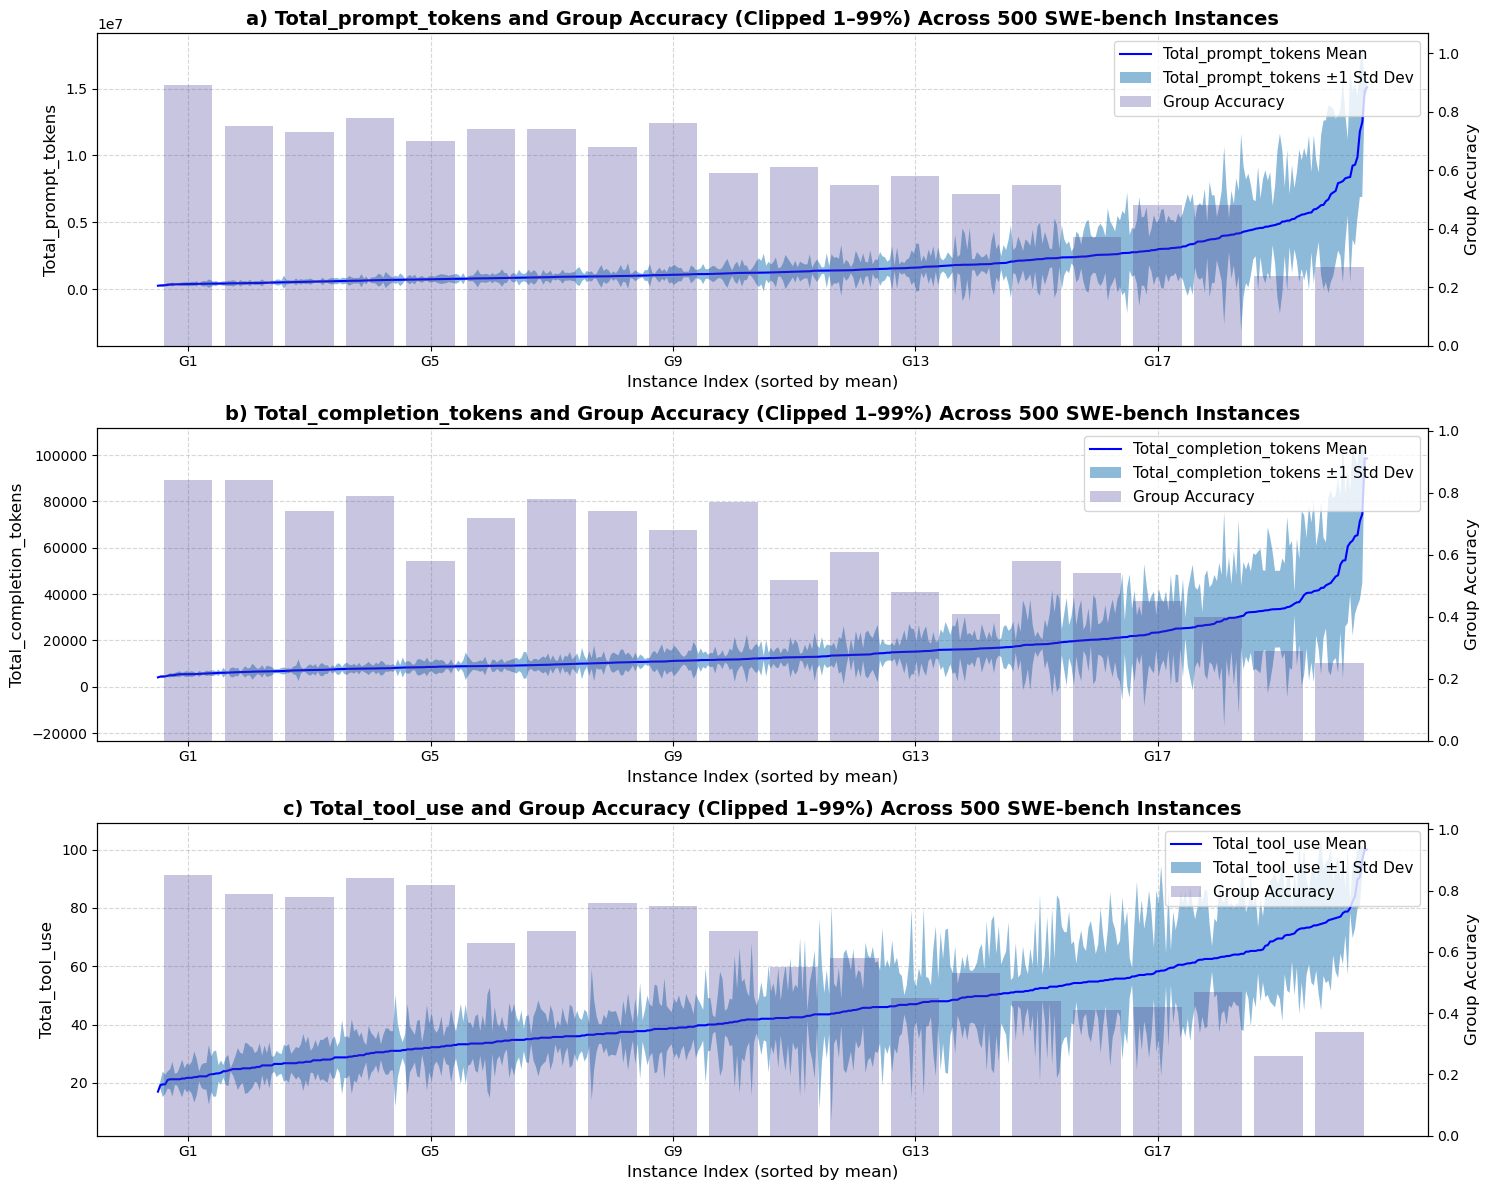

Summary of Group Accuracy Statistics by Metric:

Total_prompt_tokens:
----------------------------------------
Group  1: 0.8900 ( 89/100)  Group  2: 0.7500 ( 75/100)  Group  3: 0.7300 ( 73/100)  Group  4: 0.7800 ( 78/100)  Group  5: 0.7000 ( 70/100)  
Group  6: 0.7400 ( 74/100)  Group  7: 0.7400 ( 74/100)  Group  8: 0.6800 ( 68/100)  Group  9: 0.7600 ( 76/100)  Group 10: 0.5900 ( 59/100)  
Group 11: 0.6100 ( 61/100)  Group 12: 0.5500 ( 55/100)  Group 13: 0.5800 ( 58/100)  Group 14: 0.5200 ( 52/100)  Group 15: 0.5500 ( 55/100)  
Group 16: 0.3700 ( 37/100)  Group 17: 0.4800 ( 48/100)  Group 18: 0.4800 ( 48/100)  Group 19: 0.2400 ( 24/100)  Group 20: 0.2700 ( 27/100)  

Total_completion_tokens:
----------------------------------------
Group  1: 0.8400 ( 84/100)  Group  2: 0.8400 ( 84/100)  Group  3: 0.7400 ( 74/100)  Group  4: 0.7900 ( 79/100)  Group  5: 0.5800 ( 58/100)  
Group  6: 0.7200 ( 72/100)  Group  7: 0.7800 ( 78/100)  Group  8: 0.7400 ( 74/100)  Group  9: 0.6800 ( 68/100)  Group

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Define metrics and their corresponding run columns
metric_config = {
    "Total_prompt_tokens": [f"total_prompt_tokens_run{i}" for i in range(1, 5)],
    "Total_completion_tokens": [f"total_completion_tokens_run{i}" for i in range(1, 5)],
    "Total_tool_use": [f"total_tool_usages_run{i}" for i in range(1, 5)],
}

# Define accuracy columns
acc_cols = [f"acc_run{i}" for i in range(1, 5)]

# Define group parameters
group_size = 25
n_groups = 20

# Create a single figure with 3 subplots stacked vertically
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Process each metric and plot in its own subplot
for idx, (metric_name, cols) in enumerate(metric_config.items()):
    # Get the raw data
    vals = df[cols].astype(float)

    # Clip extreme values by percentiles
    lower = vals.stack().quantile(0.01)
    upper = vals.stack().quantile(0.99)
    vals_clipped = vals.clip(lower=lower, upper=upper)

    # Compute mean and std
    mean_vals = vals_clipped.mean(axis=1)
    std_vals = vals_clipped.std(axis=1)

    # Sort by mean for plotting
    sorted_indices = mean_vals.argsort()
    sorted_mean = mean_vals.iloc[sorted_indices].reset_index(drop=True)
    sorted_std = std_vals.iloc[sorted_indices].reset_index(drop=True)
    
    # Calculate group accuracies for this specific sorting
    group_accuracies = []
    for group in range(n_groups):
        start_idx = group * group_size
        end_idx = (group + 1) * group_size
        
        # Get the sorted indices for this group
        group_sorted_indices = sorted_indices[start_idx:end_idx]
        
        # Get accuracy for this group across all runs using the sorted indices
        group_acc = df[acc_cols].iloc[group_sorted_indices].values.flatten()
        # Calculate accuracy as passed instances / total attempts
        group_accuracy = group_acc.sum() / (group_size * 4)
        group_accuracies.append(group_accuracy)

    # Plot in the corresponding subplot
    ax = axes[idx]
    
    # Plot the main metric first (plot first, so it goes to back)
    ax.plot(sorted_mean, label=f"{metric_name} Mean", color='blue', linewidth=1.5, zorder=3)
    ax.fill_between(
        x=range(len(sorted_mean)),
        y1=sorted_mean - sorted_std,
        y2=sorted_mean + sorted_std,
        alpha=0.5,
        #color='#779ECB',
        label=f"{metric_name} ±1 Std Dev",
        zorder=2
    )
    
    # Create a second y-axis for accuracy bars
    ax2 = ax.twinx()
    
    # Plot accuracy bars for each group (plot second, so it goes to front)
    group_positions = [12.5 + i * 25 for i in range(n_groups)]  # Positions in the middle of each group
    bars = ax2.bar(group_positions, group_accuracies, width=20, alpha=0.3, 
                   color='#464196', label='Group Accuracy', zorder=1)
    
    # Set labels and titles
    import string
    letters = list(string.ascii_lowercase)
    ax.set_title(f"{letters[idx]}) {metric_name} and Group Accuracy (Clipped 1–99%) Across 500 SWE-bench Instances", 
                fontsize=14, fontweight='bold')
    ax.set_xlabel("Instance Index (sorted by mean)", fontsize=12)
    ax.set_ylabel(f"{metric_name}", color='black', fontsize=12)
    ax2.set_ylabel("Group Accuracy", color='black', fontsize=12)
    
    # Color the y-axis labels
    ax.tick_params(axis='y', labelcolor='black')
    ax2.tick_params(axis='y', labelcolor='black')
    
    # Set y-axis limits for accuracy
    ax2.set_ylim(0, max(group_accuracies) * 1.2)
    
    # Combine legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=11)
    
    ax.grid(True, linestyle="--", alpha=0.5)
    
    # Add group labels (only for every 4th group to avoid crowding)
    ax2.set_xticks([group_positions[i] for i in range(0, n_groups, 4)])
    ax2.set_xticklabels([f'G{i+1}' for i in range(0, n_groups, 4)], fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Print summary statistics for each metric
print("Summary of Group Accuracy Statistics by Metric:")
print("=" * 60)

for idx, (metric_name, cols) in enumerate(metric_config.items()):
    print(f"\n{metric_name}:")
    print("-" * 40)
    
    # Get the raw data and sort
    vals = df[cols].astype(float)
    mean_vals = vals.mean(axis=1)
    sorted_indices = mean_vals.argsort()
    
    # Calculate group accuracies for this metric
    group_accuracies = []
    for group in range(n_groups):
        start_idx = group * group_size
        end_idx = (group + 1) * group_size
        
        # Get the sorted indices for this group
        group_sorted_indices = sorted_indices[start_idx:end_idx]
        
        # Get accuracy for this group across all runs using the sorted indices
        group_acc = df[acc_cols].iloc[group_sorted_indices].values.flatten()
        # Calculate accuracy as passed instances / total attempts
        group_accuracy = group_acc.sum() / (group_size * 4)
        group_accuracies.append(group_accuracy)
    
    # Print group statistics
    for group in range(n_groups):
        start_idx = group * group_size
        end_idx = (group + 1) * group_size
        group_sorted_indices = sorted_indices[start_idx:end_idx]
        group_acc = df[acc_cols].iloc[group_sorted_indices].values.flatten()
        total_passed = int(group_acc.sum())
        total_attempts = len(group_acc)
        group_accuracy = group_accuracies[group]
        
        print(f"Group {group+1:2d}: {group_accuracy:.4f} ({total_passed:3d}/{total_attempts:3d})", end="  ")
        if (group + 1) % 5 == 0:  # New line every 5 groups
            print()


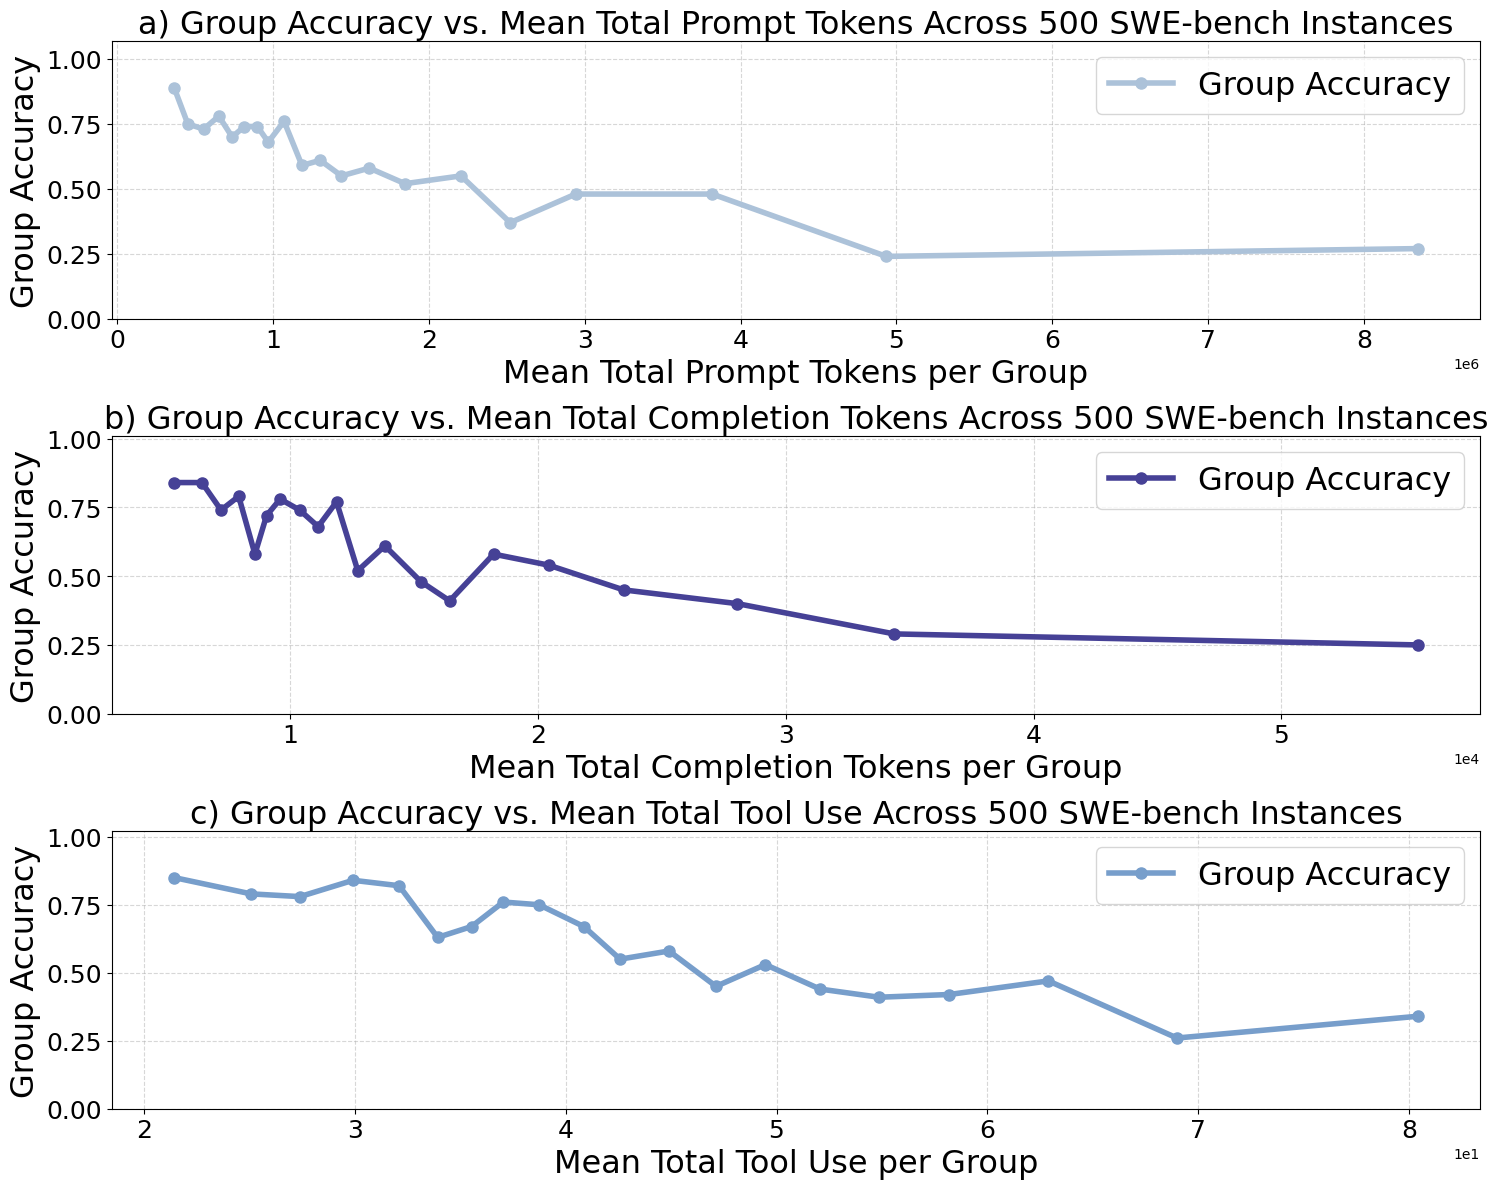

Summary of Group Accuracy Statistics by Metric:

Total Prompt Tokens:
----------------------------------------
Group  1: 0.8900 ( 89/100) - Mean Cost: 3.59e+05  Group  2: 0.7500 ( 75/100) - Mean Cost: 4.51e+05  Group  3: 0.7300 ( 73/100) - Mean Cost: 5.54e+05  
Group  4: 0.7800 ( 78/100) - Mean Cost: 6.51e+05  Group  5: 0.7000 ( 70/100) - Mean Cost: 7.36e+05  Group  6: 0.7400 ( 74/100) - Mean Cost: 8.15e+05  
Group  7: 0.7400 ( 74/100) - Mean Cost: 8.99e+05  Group  8: 0.6800 ( 68/100) - Mean Cost: 9.68e+05  Group  9: 0.7600 ( 76/100) - Mean Cost: 1.07e+06  
Group 10: 0.5900 ( 59/100) - Mean Cost: 1.18e+06  Group 11: 0.6100 ( 61/100) - Mean Cost: 1.30e+06  Group 12: 0.5500 ( 55/100) - Mean Cost: 1.44e+06  
Group 13: 0.5800 ( 58/100) - Mean Cost: 1.62e+06  Group 14: 0.5200 ( 52/100) - Mean Cost: 1.85e+06  Group 15: 0.5500 ( 55/100) - Mean Cost: 2.21e+06  
Group 16: 0.3700 ( 37/100) - Mean Cost: 2.52e+06  Group 17: 0.4800 ( 48/100) - Mean Cost: 2.94e+06  Group 18: 0.4800 ( 48/100) - Mean 

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Define metrics and their corresponding run columns
metric_config = {
    "Total Prompt Tokens": [f"total_prompt_tokens_run{i}" for i in range(1, 5)],
    "Total Completion Tokens": [f"total_completion_tokens_run{i}" for i in range(1, 5)],
    "Total Tool Use": [f"total_tool_usages_run{i}" for i in range(1, 5)],
}

# Define colors for each metric
metric_colors = {
    "Total Prompt Tokens": "#ACC2D9",      # light blue
    "Total Completion Tokens": "#464196",  # dark blue
    "Total Tool Use": "#779ECB"            # medium blue
}

# Define accuracy columns
acc_cols = [f"acc_run{i}" for i in range(1, 5)]

# Define group parameters
group_size = 25
n_groups = 20

# Create a single figure with 3 subplots stacked vertically
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Process each metric and plot in its own subplot
for idx, (metric_name, cols) in enumerate(metric_config.items()):
    # Get the raw data
    vals = df[cols].astype(float)

    # Clip extreme values by percentiles
    lower = vals.stack().quantile(0.01)
    upper = vals.stack().quantile(0.99)
    vals_clipped = vals.clip(lower=lower, upper=upper)

    # Compute mean and std
    mean_vals = vals_clipped.mean(axis=1)
    std_vals = vals_clipped.std(axis=1)

    # Sort by mean for plotting
    sorted_indices = mean_vals.argsort()
    sorted_mean = mean_vals.iloc[sorted_indices].reset_index(drop=True)
    sorted_std = std_vals.iloc[sorted_indices].reset_index(drop=True)
    
    # Calculate group accuracies and group mean costs for this specific sorting
    group_accuracies = []
    group_mean_costs = []
    
    for group in range(n_groups):
        start_idx = group * group_size
        end_idx = (group + 1) * group_size
        
        # Get the sorted indices for this group
        group_sorted_indices = sorted_indices[start_idx:end_idx]
        
        # Get accuracy for this group across all runs using the sorted indices
        group_acc = df[acc_cols].iloc[group_sorted_indices].values.flatten()
        # Calculate accuracy as passed instances / total attempts
        group_accuracy = group_acc.sum() / (group_size * 4)
        group_accuracies.append(group_accuracy)
        
        # Get mean cost for this group
        group_cost = sorted_mean[start_idx:end_idx].mean()
        group_mean_costs.append(group_cost)

    # Plot in the corresponding subplot
    ax = axes[idx]
    
    # Plot accuracy as line graph with x-axis as group mean cost
    ax.plot(group_mean_costs, group_accuracies, marker='o', linewidth=4, markersize=8,
            color=metric_colors[metric_name], label='Group Accuracy', zorder=3)
    
    # Set labels and titles
    import string
    letters = list(string.ascii_lowercase)
    ax.set_title(f"{letters[idx]}) Group Accuracy vs. Mean {metric_name} Across 500 SWE-bench Instances", 
                fontsize=23)
    ax.set_xlabel(f"Mean {metric_name} per Group", fontsize=23)
    ax.set_ylabel("Group Accuracy", fontsize=23)
    
    # Set y-axis limits for accuracy
    ax.set_ylim(0, max(group_accuracies) * 1.2)
    
    # Add legend
    ax.legend(fontsize=23)
    
    ax.grid(True, linestyle="--", alpha=0.5)
    
    # Format x-axis to show cost values nicely
    ax.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
    
    # Increase tick label font size
    ax.tick_params(axis='both', which='major', labelsize=18)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Print summary statistics for each metric
print("Summary of Group Accuracy Statistics by Metric:")
print("=" * 60)

for idx, (metric_name, cols) in enumerate(metric_config.items()):
    print(f"\n{metric_name}:")
    print("-" * 40)
    
    # Get the raw data and sort
    vals = df[cols].astype(float)
    mean_vals = vals.mean(axis=1)
    sorted_indices = mean_vals.argsort()
    sorted_mean = mean_vals.iloc[sorted_indices].reset_index(drop=True)
    
    # Calculate group accuracies and costs for this metric
    group_accuracies = []
    group_mean_costs = []
    
    for group in range(n_groups):
        start_idx = group * group_size
        end_idx = (group + 1) * group_size
        
        # Get the sorted indices for this group
        group_sorted_indices = sorted_indices[start_idx:end_idx]
        
        # Get accuracy for this group across all runs using the sorted indices
        group_acc = df[acc_cols].iloc[group_sorted_indices].values.flatten()
        # Calculate accuracy as passed instances / total attempts
        group_accuracy = group_acc.sum() / (group_size * 4)
        group_accuracies.append(group_accuracy)
        
        # Get mean cost for this group
        group_cost = sorted_mean[start_idx:end_idx].mean()
        group_mean_costs.append(group_cost)
    
    # Print group statistics
    for group in range(n_groups):
        start_idx = group * group_size
        end_idx = (group + 1) * group_size
        group_sorted_indices = sorted_indices[start_idx:end_idx]
        group_acc = df[acc_cols].iloc[group_sorted_indices].values.flatten()
        total_passed = int(group_acc.sum())
        total_attempts = len(group_acc)
        group_accuracy = group_accuracies[group]
        
        print(f"Group {group+1:2d}: {group_accuracy:.4f} ({total_passed:3d}/{total_attempts:3d}) - Mean Cost: {group_mean_costs[group]:.2e}", end="  ")
        if (group + 1) % 3 == 0:  # New line every 3 groups to accommodate the cost info
            print()
    
    # Calculate correlation between cost and accuracy
    correlation = np.corrcoef(group_mean_costs, group_accuracies)[0, 1]
    print(f"\nCorrelation between mean {metric_name} and group accuracy: {correlation:.4f}")


In [5]:
display(df)

,repo,instance_id,base_commit,patch,test_patch,problem_statement,hints_text,created_at,version,FAIL_TO_PASS,...,total_tool_usage_think_cv,total_tool_usage_finish_mean,total_tool_usage_finish_var,total_tool_usage_finish_cv,total_interaction_rounds_mean,total_interaction_rounds_var,total_interaction_rounds_cv,total_cost_mean,total_cost_var,total_cost_cv
0,astropy/astropy,astropy__astropy-12907,d16bfe05a744909de4b27f5875fe0d4ed41ce607,diff --git a/astropy/modeling/separable.py b/a...,diff --git a/astropy/modeling/tests/test_separ...,Modeling's `separability_matrix` does not comp...,NaN,2022-03-03T15:14:54Z,4.30,"[""astropy/modeling/tests/test_separable.py::te...",...,0.547101,1.0,0.0,0.0,50.75,150.916667,0.242065,1.042457,0.060247,0.235455
1,astropy/astropy,astropy__astropy-13033,298ccb478e6bf092953bca67a3d29dc6c35f6752,diff --git a/astropy/timeseries/core.py b/astr...,diff --git a/astropy/timeseries/tests/test_sam...,TimeSeries: misleading exception when required...,The relevant code that produces the misleading...,2022-03-31T23:28:27Z,4.30,"[""astropy/timeseries/tests/test_sampled.py::te...",...,2.000000,1.0,0.0,0.0,29.25,70.250000,0.286548,0.438699,0.023909,0.352466
2,astropy/astropy,astropy__astropy-13236,6ed769d58d89380ebaa1ef52b300691eefda8928,diff --git a/astropy/table/table.py b/astropy/...,diff --git a/astropy/table/tests/test_mixin.py...,Consider removing auto-transform of structured...,@mhvk - I'm happy to do this PR if you think i...,2022-05-09T14:16:30Z,5.00,"[""astropy/table/tests/test_mixin.py::test_ndar...",...,2.000000,1.0,0.0,0.0,42.75,694.916667,0.616638,0.755433,0.236207,0.643355
3,astropy/astropy,astropy__astropy-13398,6500928dc0e57be8f06d1162eacc3ba5e2eff692,diff --git a/astropy/coordinates/builtin_frame...,diff --git a/astropy/coordinates/tests/test_in...,A direct approach to ITRS to Observed transfor...,"cc @StuartLittlefair, @adrn, @eteq, @eerovaher...",2022-06-24T15:22:11Z,5.00,"[""astropy/coordinates/tests/test_intermediate_...",...,2.000000,1.0,0.0,0.0,36.50,15.000000,0.106109,0.826533,0.063355,0.304531
4,astropy/astropy,astropy__astropy-13453,19cc80471739bcb67b7e8099246b391c355023ee,diff --git a/astropy/io/ascii/html.py b/astrop...,diff --git a/astropy/io/ascii/tests/test_html....,ASCII table output to HTML does not support su...,Welcome to Astropy 👋 and thank you for your fi...,2022-07-14T10:04:40Z,5.00,"[""astropy/io/ascii/tests/test_html.py::test_wr...",...,1.154701,1.0,0.0,0.0,101.25,2441.583333,0.488024,2.192714,1.308500,0.521681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,sympy/sympy,sympy__sympy-24213,e8c22f6eac7314be8d92590bfff92ced79ee03e2,diff --git a/sympy/physics/units/unitsystem.py...,diff --git a/sympy/physics/units/tests/test_qu...,collect_factor_and_dimension does not detect e...,NaN,2022-11-03T14:00:09Z,1.12,"[""test_issue_24211""]",...,2.000000,1.0,0.0,0.0,38.50,301.666667,0.451131,0.691023,0.177066,0.608941
496,sympy/sympy,sympy__sympy-24443,809c53c077485ca48a206cee78340389cb83b7f1,diff --git a/sympy/combinatorics/homomorphisms...,diff --git a/sympy/combinatorics/tests/test_ho...,`_check_homomorphism` is broken on Permutation...,NaN,2022-12-30T14:43:19Z,1.12,"[""test_homomorphism""]",...,0.816497,1.0,0.0,0.0,126.50,6805.666667,0.652146,3.219132,8.466721,0.903897
497,sympy/sympy,sympy__sympy-24539,193e3825645d93c73e31cdceb6d742cc6919624d,diff --git a/sympy/polys/rings.py b/sympy/poly...,diff --git a/sympy/polys/tests/test_rings.py b...,`PolyElement.as_expr()` not accepting symbols\...,NaN,2023-01-17T17:26:42Z,1.12,"[""test_PolyElement_as_expr""]",...,0.000000,1.0,0.0,0.0,28.00,18.000000,0.151523,0.404140,0.003779,0.152106
498,sympy/sympy,sympy__sympy-24562,b1cb676cf92dd1a48365b731979833375b188bf2,diff --git a/sympy/core/numbers.py b/sympy/cor...,diff --git a/sympy/core/tests/test_numbers.py ...,"Rational calc value error\npython 3.11, sympy ...",This should probably raise an error. The expec...,2023-01-21T12:06:36Z,1.12,"[""test_issue_2

In [7]:
# Collect all CV columns
cv_columns = [col for col in df.columns if col.endswith("_cv")]

# Calculate average CV across rows for each metric
avg_cvs = {col.replace("_cv", ""): df[col].mean() for col in cv_columns}

# Sort by CV (descending)
sorted_avg_cvs = dict(sorted(avg_cvs.items(), key=lambda x: x[1], reverse=True))

# Print nicely
print("Average CV (coefficient of variation) per metric across 500 instances:")
for metric, avg_cv in sorted_avg_cvs.items():
    print(f"{metric:45} →  CV: {avg_cv:.4f}")

Average CV (coefficient of variation) per metric across 500 instances:
total_tool_usage_think                        →  CV: 1.1483
total_cache_read_input_tokens                 →  CV: 0.5481
total_cached_tokens                           →  CV: 0.5481
total_prompt_tokens                           →  CV: 0.5413
total_total_tokens                            →  CV: 0.5398
total_cost                                    →  CV: 0.4515
total_completion_tokens                       →  CV: 0.4263
total_cache_creation_input_tokens             →  CV: 0.3735
total_interaction_rounds                      →  CV: 0.3732
total_tool_usage_str_replace_editor           →  CV: 0.3519
total_tool_usages                             →  CV: 0.2644
total_tool_usage_execute_bash                 →  CV: 0.2641
total_tool_usage_finish                       →  CV: 0.0000


In [8]:
# Step 1: Identify per-run metric columns
run_metrics = [
    "total_prompt_tokens", "total_completion_tokens", "total_total_tokens",
    "total_cache_creation_input_tokens", "total_cache_read_input_tokens", "total_cached_tokens",
    "total_tool_usages", "total_tool_usage_str_replace_editor", "total_tool_usage_execute_bash",
    "total_tool_usage_think", "total_tool_usage_finish", "total_interaction_rounds", "total_cost"
]

# Step 2: Prepare the new rows
mean_row = {}
var_row = {}
cv_row = {}

for metric in run_metrics:
    run_cols = [f"{metric}_run{i}" for i in range(1, 5)]
    values = df[run_cols]

    # Compute and assign mean, var, and cv
    for col in run_cols:
        col_values = df[col]
        mean_row[col] = col_values.mean()
        var_row[col] = col_values.var()
        cv_row[col] = np.std(col_values) / np.mean(col_values) if np.mean(col_values) != 0 else 0

    # Leave aggregated mean/var/cv columns blank
    mean_row[f"{metric}_mean"] = ""
    var_row[f"{metric}_var"] = ""
    cv_row[f"{metric}_cv"] = ""

# Label rows
mean_row["instance_id"] = "mean"
var_row["instance_id"] = "var"
cv_row["instance_id"] = "cv"

# Step 3: Append to DataFrame
df = pd.concat([df, pd.DataFrame([mean_row, var_row, cv_row])], ignore_index=True)





In [9]:
display(df)

,repo,instance_id,base_commit,patch,test_patch,problem_statement,hints_text,created_at,version,FAIL_TO_PASS,...,total_tool_usage_think_cv,total_tool_usage_finish_mean,total_tool_usage_finish_var,total_tool_usage_finish_cv,total_interaction_rounds_mean,total_interaction_rounds_var,total_interaction_rounds_cv,total_cost_mean,total_cost_var,total_cost_cv
0,astropy/astropy,astropy__astropy-12907,d16bfe05a744909de4b27f5875fe0d4ed41ce607,diff --git a/astropy/modeling/separable.py b/a...,diff --git a/astropy/modeling/tests/test_separ...,Modeling's `separability_matrix` does not comp...,NaN,2022-03-03T15:14:54Z,4.30,"[""astropy/modeling/tests/test_separable.py::te...",...,0.547101,1.0,0.0,0.0,50.75,150.916667,0.242065,1.042457,0.060247,0.235455
1,astropy/astropy,astropy__astropy-13033,298ccb478e6bf092953bca67a3d29dc6c35f6752,diff --git a/astropy/timeseries/core.py b/astr...,diff --git a/astropy/timeseries/tests/test_sam...,TimeSeries: misleading exception when required...,The relevant code that produces the misleading...,2022-03-31T23:28:27Z,4.30,"[""astropy/timeseries/tests/test_sampled.py::te...",...,2.0,1.0,0.0,0.0,29.25,70.25,0.286548,0.438699,0.023909,0.352466
2,astropy/astropy,astropy__astropy-13236,6ed769d58d89380ebaa1ef52b300691eefda8928,diff --git a/astropy/table/table.py b/astropy/...,diff --git a/astropy/table/tests/test_mixin.py...,Consider removing auto-transform of structured...,@mhvk - I'm happy to do this PR if you think i...,2022-05-09T14:16:30Z,5.00,"[""astropy/table/tests/test_mixin.py::test_ndar...",...,2.0,1.0,0.0,0.0,42.75,694.916667,0.616638,0.755433,0.236207,0.643355
3,astropy/astropy,astropy__astropy-13398,6500928dc0e57be8f06d1162eacc3ba5e2eff692,diff --git a/astropy/coordinates/builtin_frame...,diff --git a/astropy/coordinates/tests/test_in...,A direct approach to ITRS to Observed transfor...,"cc @StuartLittlefair, @adrn, @eteq, @eerovaher...",2022-06-24T15:22:11Z,5.00,"[""astropy/coordinates/tests/test_intermediate_...",...,2.0,1.0,0.0,0.0,36.5,15.0,0.106109,0.826533,0.063355,0.304531
4,astropy/astropy,astropy__astropy-13453,19cc80471739bcb67b7e8099246b391c355023ee,diff --git a/astropy/io/ascii/html.py b/astrop...,diff --git a/astropy/io/ascii/tests/test_html....,ASCII table output to HTML does not support su...,Welcome to Astropy 👋 and thank you for your fi...,2022-07-14T10:04:40Z,5.00,"[""astropy/io/ascii/tests/test_html.py::test_wr...",...,1.154701,1.0,0.0,0.0,101.25,2441.583333,0.488024,2.192714,1.3085,0.521681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,sympy/sympy,sympy__sympy-24562,b1cb676cf92dd1a48365b731979833375b188bf2,diff --git a/sympy/core/numbers.py b/sympy/cor...,diff --git a/sympy/core/tests/test_numbers.py ...,"Rational calc value error\npython 3.11, sympy ...",This should probably raise an error. The expec...,2023-01-21T12:06:36Z,1.12,"[""test_issue_24543""]",...,1.276569,1.0,0.0,0.0,37.0,64.666667,0.217339,0.665183,0.02684,0.246293
499,sympy/sympy,sympy__sympy-24661,a36caf5c74fe654cedc488e8a8a05fad388f8406,diff --git a/sympy/parsing/sympy_parser.py b/s...,diff --git a/sympy/parsing/tests/test_sympy_pa...,The evaluate=False parameter to `parse_expr` i...,Actually this problem is not only for this but...,2023-02-05T19:15:22Z,1.12,"[""test_issue_24288""]",...,1.154701,1.0,0.0,0.0,64.25,698.916667,0.411471,1.358424,0.836422,0.673252
500,NaN,mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,,NaN,NaN,,NaN,NaN,,NaN,NaN
501,NaN,var,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,,NaN,NaN,,NaN,NaN,,NaN


In [10]:
# Step 4 (Updated): Print average CV across 4 runs, sorted high to low
cv_summary = []

for metric in run_metrics:
    cv_vals = [cv_row.get(f"{metric}_run{i}", 0) for i in range(1, 5)]
    avg_cv = np.mean(cv_vals)
    cv_summary.append((metric, avg_cv))

# Sort by CV descending
cv_summary_sorted = sorted(cv_summary, key=lambda x: x[1], reverse=True)

print("\nAverage CV across 4 runs per metric (sorted high → low):")
for metric, avg_cv in cv_summary_sorted:
    print(f"{metric:45} →  Avg CV: {avg_cv:.4f}")


Average CV across 4 runs per metric (sorted high → low):
total_cache_read_input_tokens                 →  Avg CV: 1.4016
total_cached_tokens                           →  Avg CV: 1.4016
total_prompt_tokens                           →  Avg CV: 1.3888
total_total_tokens                            →  Avg CV: 1.3855
total_tool_usage_think                        →  Avg CV: 1.3515
total_cost                                    →  Avg CV: 1.1853
total_cache_creation_input_tokens             →  Avg CV: 1.0588
total_completion_tokens                       →  Avg CV: 1.0411
total_interaction_rounds                      →  Avg CV: 0.9017
total_tool_usage_str_replace_editor           →  Avg CV: 0.5891
total_tool_usages                             →  Avg CV: 0.4389
total_tool_usage_execute_bash                 →  Avg CV: 0.4021
total_tool_usage_finish                       →  Avg CV: 0.0000


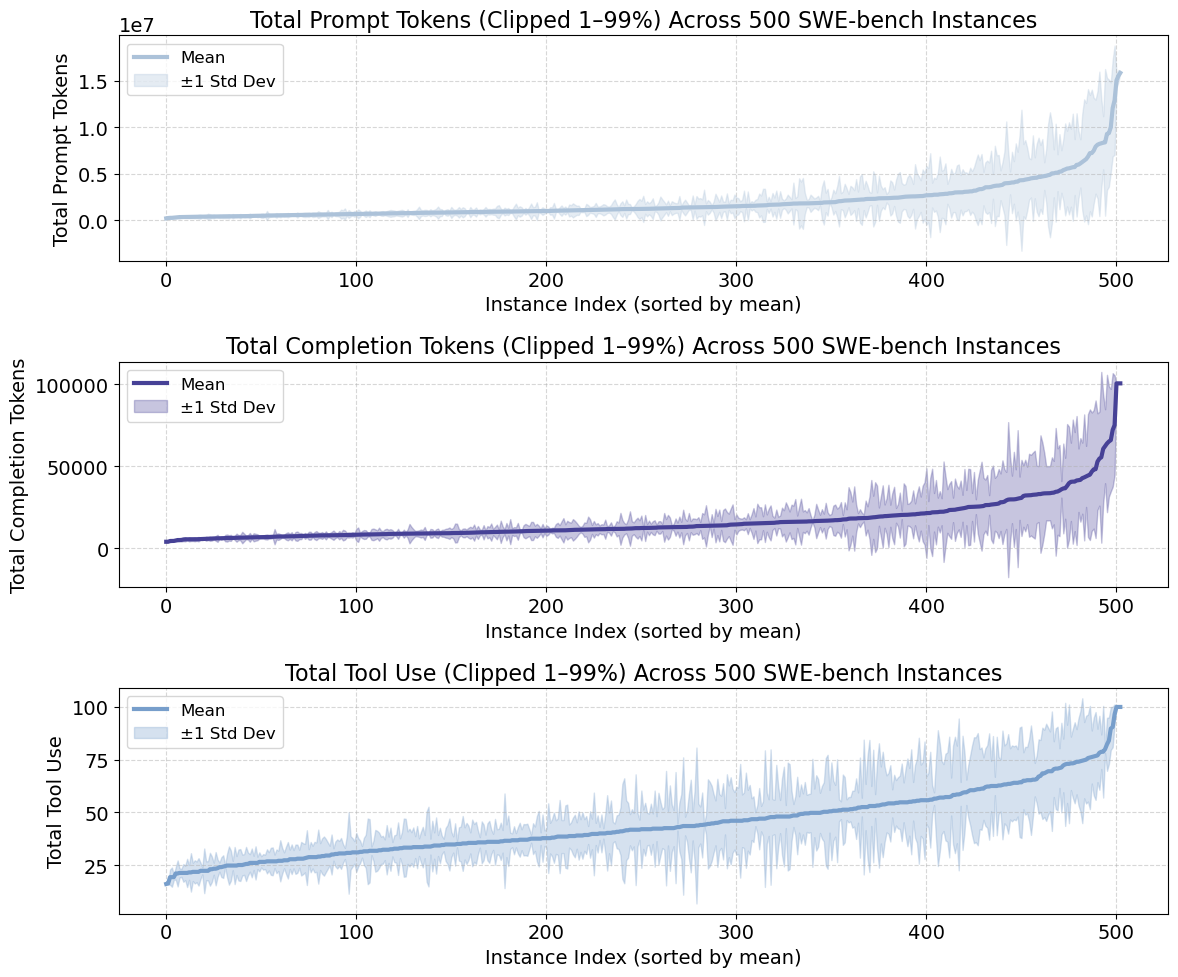

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Set larger font sizes globally
plt.rcParams.update({'font.size': 14})

# Define metrics and their corresponding run columns
metric_config = {
    "Total Prompt Tokens": [f"total_prompt_tokens_run{i}" for i in range(1, 5)],
    "Total Completion Tokens": [f"total_completion_tokens_run{i}" for i in range(1, 5)],
    "Total Tool Use": [f"total_tool_usages_run{i}" for i in range(1, 5)],
}

# Define colors for each metric
metric_colors = {
    "Total Prompt Tokens": "#ACC2D9",      # light blue
    "Total Completion Tokens": "#464196",  # dark blue
    "Total Tool Use": "#779ECB"            # medium blue
}

# Create a single figure with 3 subplots stacked vertically
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Process each metric and plot in its own subplot
for idx, (metric_name, cols) in enumerate(metric_config.items()):
    # Get the raw data
    vals = df[cols].astype(float)

    # Clip extreme values by percentiles
    lower = vals.stack().quantile(0.01)
    upper = vals.stack().quantile(0.99)
    vals_clipped = vals.clip(lower=lower, upper=upper)

    # Compute mean and std
    mean_vals = vals_clipped.mean(axis=1)
    std_vals = vals_clipped.std(axis=1)

    # Sort by mean for plotting
    sorted_indices = mean_vals.argsort()
    sorted_mean = mean_vals.iloc[sorted_indices].reset_index(drop=True)
    sorted_std = std_vals.iloc[sorted_indices].reset_index(drop=True)

    # Plot in the corresponding subplot
    ax = axes[idx]
    ax.plot(sorted_mean, label="Mean", color=metric_colors[metric_name], linewidth=3)
    ax.fill_between(
        x=range(len(sorted_mean)),
        y1=sorted_mean - sorted_std,
        y2=sorted_mean + sorted_std,
        alpha=0.3,
        label="±1 Std Dev",
        color=metric_colors[metric_name]
    )
    ax.set_title(f"{metric_name} (Clipped 1–99%) Across 500 SWE-bench Instances", fontsize=16)
    ax.set_xlabel("Instance Index (sorted by mean)", fontsize=14)
    ax.set_ylabel(metric_name, fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()




